In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import cv2
import os

import datetime

%matplotlib inline

In [31]:
class diffuseCAM(object):
    
    def __init__(self,cam_idx=0,window_name='diffuseCAM',**kwargs):
        self.window_name = window_name
        self.sess = str(datetime.datetime.now()).replace(':','-')
        self.counter=0
        self.cam_idx=cam_idx
        super(diffuseCAM,self).__init__(**kwargs)
    
    def preview(self):
        self.start()
        if self.cam.isOpened(): # try to get the first frame
            rval, frame = self.cam.read()
        else:
            rval = False
        while rval:
            cv2.imshow(self.window_name, frame)
            rval, frame = self.cam.read()
            keypress = cv2.waitKey(20)
            if keypress == 27: # exit on ESC
                break
            elif keypress == ord('q'):
                frame = self.BGR2RGB(frame)
                plt.imsave('../data/unsorted/dc_%d_%s.png'%(self.counter,
                                                            self.sess),frame)
                self.counter +=1
        self.close()
        
    def close(self):
        cv2.destroyWindow(self.window_name)
        self.cam.release()
        
    def start(self):
        cv2.namedWindow(self.window_name)
        self.cam = cv2.VideoCapture(self.cam_idx)
        if not self.cam.isOpened():
            raise RuntimeError('Could not start camera')
    
    def capture(self,folder='unsorted'):
        self.start()
        _, frame = self.cam.read()
        self.close()
        frame = self.BGR2RGB(frame)
        plt.imsave('../data/%s/dc_%d_%s.png'%(folder,self.counter,self.sess),frame)
        self.counter +=1
        return frame
    
    def BGR2RGB(self,frame):
        frame = [frame[:,:,2],frame[:,:,1],frame[:,:,0]]
        return np.asarray(np.swapaxes(np.swapaxes(frame,0,2),0,1),dtype=np.float32)/255
    
    def calibrate_dark(self,num_frames=10):
        self.start()
        _, img = self.cam.read()
        img = self.BGR2RGB(img)
        for idx in range(num_frames-1):
            _, frame = self.cam.read()
            frame = self.BGR2RGB(frame)
            img += frame
        self.dark = img/num_frames
        self.close()
        
dC = diffuseCAM(0)

In [34]:
dC.calibrate_dark()

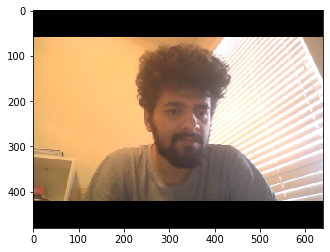

In [28]:
img = dC.capture()
plt.imshow(img)

In [20]:
dC.preview()

In [33]:
def imread(fname,resize=None,grayscale=True):
    img = cv2.imread(fname)
    if resize is not None:
        img = cv2.resize(img,resize,cv2.INTER_LANCZOS4)
    if grayscale:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.asarray(img,dtype=np.float32)/255